<a href="https://colab.research.google.com/github/AugustoBonifacio001/AugustoBonifacio001/blob/main/evento_spike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MSE: 0.0158


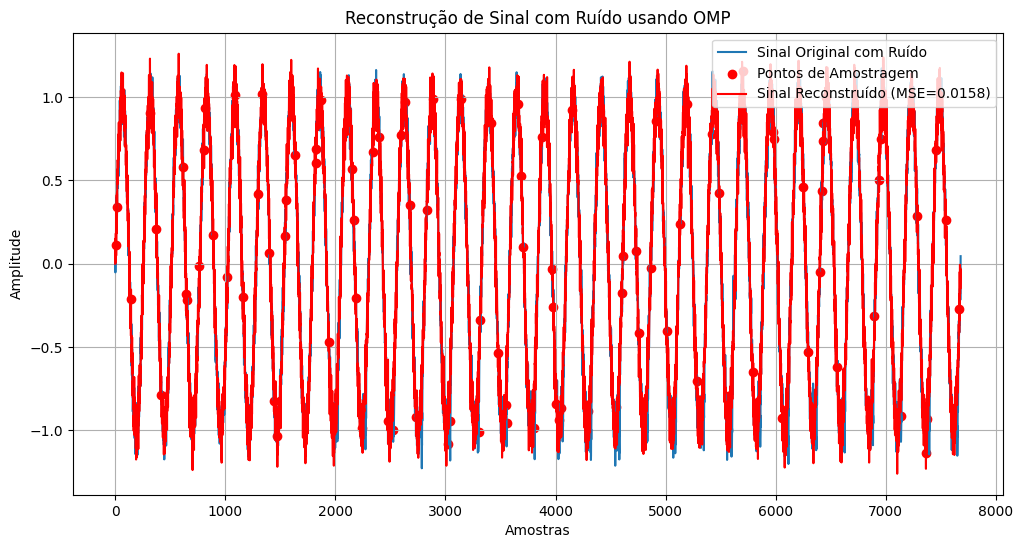

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit

def omp(Phi, u, s):
    omp_model = OrthogonalMatchingPursuit(n_nonzero_coefs=s)
    omp_model.fit(Phi, u)
    return omp_model.coef_

def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

def evento_spike(SNRdb):
    Vm1 = 1
    fase = 0
    FreqFund = 60
    Npc = 256
    Nc = 30
    Npt = Nc * Npc
    Fs = Npc * 60
    T = 1 / Fs

    w0 = 2 * np.pi * FreqFund
    t = np.arange(0, T * Npt, T)
    x1 = Vm1 * np.sin(w0 * t + fase)

    k = 0
    while abs(k) < 0.6:
        no = np.random.randint(7 * Npc, 8 * Npc)
        k = x1[no]

    n2 = 1
    n3 = 10
    periodo = Npc
    dist = np.zeros(Nc * Npc)

    for n1 in range(Nc * Npc):
        if no < n1 < no + 21:
            if no < n1 < no + 11:
                dist[n1] = (0.5 * k / 10) * n2
                n2 += 1
            if no + 10 <= n1 < no + 21:
                dist[n1] = (0.5 * k / 10) * n3
                n3 -= 1
        else:
            if n1 == no + 21:
                no += periodo
                n2 = 1
                n3 = 10
            dist[n1] = 0

    Ps = (Vm1 ** 2) / 2
    Pr = Ps / (10 ** (SNRdb / 10))
    desvio = np.sqrt(Pr)
    R = np.random.normal(0, desvio, Nc * Npc)
    R -= np.mean(R)

    xIn = x1 + dist + R

    return xIn, Nc, FreqFund

# Parâmetros
SNRdb = 20  # Relação sinal-ruído desejada

# Gera o evento spike e obtém o sinal com ruído
xIn, _, _ = evento_spike(SNRdb)

# Configurações para a amostragem
n = len(xIn)
p = 100  # Número de amostras aleatórias

# Amostragem aleatória do sinal ruidoso
amostras_aleatorias = np.round((n - 1) * np.random.rand(p)).astype(int)
y = xIn[amostras_aleatorias]

# Matriz de amostragem
Phi = np.fft.fft(np.eye(n, n)) * 1
CPhi = np.imag(Phi[amostras_aleatorias, :])

# OMP para minimização de l1
s_reconstruido = omp(CPhi, y, 10)

# Sinal reconstruído
x_rec = np.imag(np.fft.fft(s_reconstruido))

# Calcular a taxa de erro usando o MSE
mse_omp = calculate_mse(xIn, x_rec)
print(f'MSE: {mse_omp:.4f}')

# Visualizar o sinal original com ruído, pontos de amostragem aleatória e reconstrução
plt.figure(figsize=(12, 6))
plt.plot(xIn, label='Sinal Original com Ruído')
plt.scatter(amostras_aleatorias, y, color='red', label='Pontos de Amostragem')
plt.plot(x_rec, 'r', label=f'Sinal Reconstruído (MSE={mse_omp:.4f})')
plt.title('Reconstrução de Sinal com Ruído usando OMP')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


MSE (CoSaMP): 0.7248


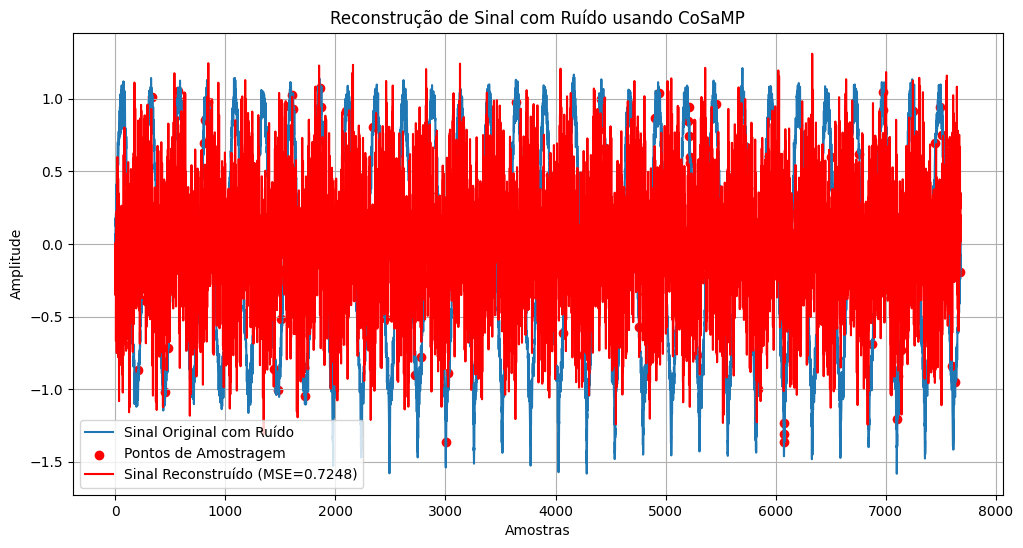

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit

def cosamp(Phi, u, s, epsilon=1e-10, max_iter=500):
    m, n = Phi.shape
    x = np.zeros(n)
    t = 0
    r = u.copy()

    while t < s and t < max_iter:
        y = np.abs(np.dot(Phi.T, r))
        Omega = np.argsort(y)[::-1][:2 * s]
        T = np.union1d(Omega, np.where(np.abs(x) > epsilon)[0])
        phi_T = Phi[:, T]

        indices = np.argsort(np.abs(np.dot(np.linalg.pinv(phi_T), u)))
        Omega = T[indices[:s]]

        A_T = Phi[:, Omega]

        # Atualização de x
        x = np.zeros(n)
        x[Omega] = np.dot(np.linalg.pinv(A_T), u)

        # Atualização de r
        r = u - np.dot(Phi, x)

        t += 1

    return x

def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

def evento_spike(SNRdb):
    Vm1 = 1
    fase = 0
    FreqFund = 60
    Npc = 256
    Nc = 30
    Npt = Nc * Npc
    Fs = Npc * 60
    T = 1 / Fs

    w0 = 2 * np.pi * FreqFund
    t = np.arange(0, T * Npt, T)
    x1 = Vm1 * np.sin(w0 * t + fase)

    k = 0
    while abs(k) < 0.6:
        no = np.random.randint(7 * Npc, 8 * Npc)
        k = x1[no]

    n2 = 1
    n3 = 10
    periodo = Npc
    dist = np.zeros(Nc * Npc)

    for n1 in range(Nc * Npc):
        if no < n1 < no + 21:
            if no < n1 < no + 11:
                dist[n1] = (0.5 * k / 10) * n2
                n2 += 1
            if no + 10 <= n1 < no + 21:
                dist[n1] = (0.5 * k / 10) * n3
                n3 -= 1
        else:
            if n1 == no + 21:
                no += periodo
                n2 = 1
                n3 = 10
            dist[n1] = 0

    Ps = (Vm1 ** 2) / 2
    Pr = Ps / (10 ** (SNRdb / 10))
    desvio = np.sqrt(Pr)
    R = np.random.normal(0, desvio, Nc * Npc)
    R -= np.mean(R)

    xIn = x1 + dist + R

    return xIn, Nc, FreqFund

# Parâmetros
SNRdb = 20  # Relação sinal-ruído desejada

# Gera o evento spike e obtém o sinal com ruído
xIn, _, _ = evento_spike(SNRdb)

# Configurações para a amostragem
n = len(xIn)
p = 100  # Número de amostras aleatórias

# Amostragem aleatória do sinal ruidoso
amostras_aleatorias = np.round((n - 1) * np.random.rand(p)).astype(int)
y = xIn[amostras_aleatorias]

# Matriz de amostragem
Phi = np.fft.fft(np.eye(n, n)) * 1
CPhi = np.imag(Phi[amostras_aleatorias, :])

# CoSaMP para minimização de l1
s_reconstruido = cosamp(CPhi, y, 10)

# Sinal reconstruído
x_rec = np.imag(np.fft.fft(s_reconstruido))

# Calcular a taxa de erro usando o MSE
mse_cosamp = calculate_mse(xIn, x_rec)
print(f'MSE (CoSaMP): {mse_cosamp:.4f}')

# Visualizar o sinal original com ruído, pontos de amostragem aleatória e reconstrução
plt.figure(figsize=(12, 6))
plt.plot(xIn, label='Sinal Original com Ruído')
plt.scatter(amostras_aleatorias, y, color='red', label='Pontos de Amostragem')
plt.plot(x_rec, 'r', label=f'Sinal Reconstruído (MSE={mse_cosamp:.4f})')
plt.title('Reconstrução de Sinal com Ruído usando CoSaMP')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()
